In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn


0: 256x320 9 License_Plates, 100.8ms
Speed: 6.8ms preprocess, 100.8ms inference, 163.5ms postprocess per image at shape (1, 3, 256, 320)


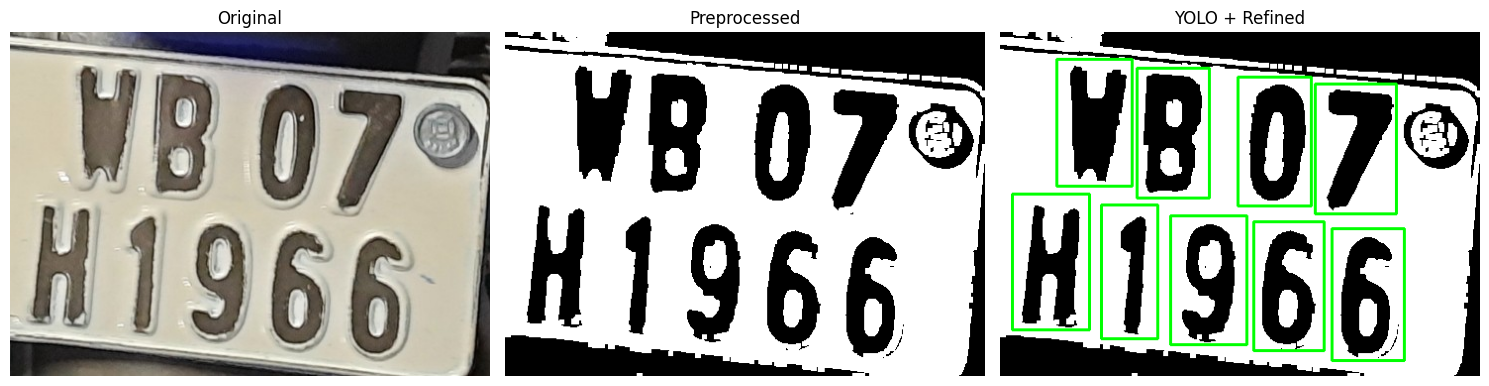

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# -------------------------
# Load YOLO model
# -------------------------
model = YOLO("best.pt")

# -------------------------
# Input image path
# -------------------------
orig_path = r"img\img11.jpg"

# -------------------------
# Preprocess the image
# -------------------------
img = cv2.imread(orig_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

inv = cv2.bitwise_not(thresh)
kernel = np.ones((3, 3), np.uint8)
closed = cv2.morphologyEx(inv, cv2.MORPH_CLOSE, kernel, iterations=2)
pre_img = cv2.bitwise_not(closed)

# Save temporarily (optional)
pre_path = r"img\preprocessed.png"
cv2.imwrite(pre_path, pre_img)

# -------------------------
# Run YOLO on preprocessed
# -------------------------
pre_rgb = cv2.cvtColor(pre_img, cv2.COLOR_GRAY2BGR)
results = model(pre_rgb)

refined_boxes = []
H, W = pre_img.shape[:2]

# Helper function to remove overlapping boxes
def remove_overlaps(boxes, overlap_thresh=0.5):
    if len(boxes) == 0:
        return boxes
    
    filtered_boxes = []
    boxes = sorted(boxes, key=lambda x: (x[2] - x[0]) * (x[3] - x[1]), reverse=True)  # Sort by area
    
    for box in boxes:
        x1, y1, x2, y2 = box
        area1 = (x2 - x1) * (y2 - y1)
        
        keep = True
        for existing_box in filtered_boxes:
            ex1, ey1, ex2, ey2 = existing_box
            
            # Calculate intersection
            ix1 = max(x1, ex1)
            iy1 = max(y1, ey1)
            ix2 = min(x2, ex2)
            iy2 = min(y2, ey2)
            
            if ix1 < ix2 and iy1 < iy2:
                intersection = (ix2 - ix1) * (iy2 - iy1)
                area2 = (ex2 - ex1) * (ey2 - ey1)
                
                # Calculate overlap ratio
                overlap_ratio = intersection / min(area1, area2)
                if overlap_ratio > overlap_thresh:
                    keep = False
                    break
        
        if keep:
            filtered_boxes.append(box)
    
    return filtered_boxes

for r in results:
    if r.boxes is None:
        continue
    
    # Get confidence scores if available
    confidences = r.boxes.conf.cpu().numpy() if r.boxes.conf is not None else [1.0] * len(r.boxes.xyxy)
    
    for box, conf in zip(r.boxes.xyxy.cpu().numpy(), confidences):
        # Filter by confidence threshold
        if conf < 0.4:  # Adjust this value as needed
            continue
            
        x1, y1, x2, y2 = map(int, box)
        x1, y1, x2, y2 = max(0, x1), max(0, y1), min(W, x2), min(H, y2)
        
        # Filter by box dimensions
        box_w, box_h = x2 - x1, y2 - y1
        if box_w < 10 or box_h < 15 or box_w > 100 or box_h > 150:  # Adjust these values
            continue
        
        # Filter by aspect ratio (characters are typically taller than wide)
        aspect_ratio = box_h / box_w
        if aspect_ratio < 0.8 or aspect_ratio > 4.0:  # Adjust these values
            continue
        
        roi = pre_img[y1:y2, x1:x2]
        if roi.size == 0:
            continue

        contours, _ = cv2.findContours(roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Find the largest contour in the ROI
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            if cv2.contourArea(largest_contour) < 50:  # Increased minimum area
                continue
                
            x, y, w, h = cv2.boundingRect(largest_contour)
            
            # Additional filtering for refined boxes
            if w < 8 or h < 10:  # Minimum character size
                continue
                
            refined_boxes.append((x1 + x, y1 + y, x1 + x + w, y1 + y + h))

# Remove overlapping boxes
refined_boxes = remove_overlaps(refined_boxes, overlap_thresh=0.3)

# Sort left-to-right
chars = sorted(refined_boxes, key=lambda b: b[0])

# -------------------------
# Draw boxes on preprocessed
# -------------------------
dbg = cv2.cvtColor(pre_img, cv2.COLOR_GRAY2BGR)
for (x1, y1, x2, y2) in chars:
    cv2.rectangle(dbg, (x1, y1), (x2, y2), (0, 255, 0), 2)

# -------------------------
# Plot results
# -------------------------
orig_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(orig_rgb)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(pre_img, cmap="gray")
plt.title("Preprocessed")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(dbg, cv2.COLOR_BGR2RGB))
plt.title("YOLO + Refined")
plt.axis("off")

plt.tight_layout()
plt.show()


In [3]:
char_crops = []
for (x1, y1, x2, y2) in chars:
    pad = 5
    x0 = max(0, x1 - pad)
    y0 = max(0, y1 - pad)
    x1p = min(W, x2 + pad)
    y1p = min(H, y2 + pad)

    crop = img[y0:y1p, x0:x1p]
    if crop.size:
        char_crops.append(crop)

print(f"crops: {len(char_crops)}")


crops: 9


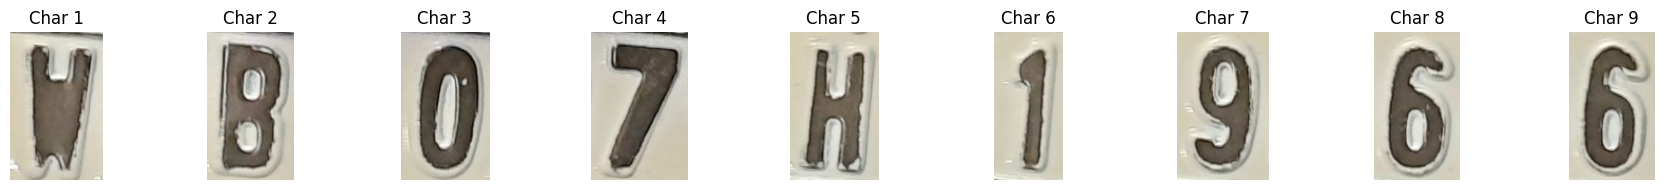

In [4]:
import math

# Sort by row (y), then by column (x)
# chars = [(x1, y1, x2, y2), ...] from YOLO/refinement
# You must keep the same chars list you used for cropping
sorted_chars = sorted(chars, key=lambda b: (b[1]//50, b[0]))  # 50 = row threshold (tune if needed)

# Now crop again in order
ordered_crops = []
for (x1, y1, x2, y2) in sorted_chars:
    pad = 5
    x0 = max(0, x1 - pad)
    y0 = max(0, y1 - pad)
    x1p = min(W, x2 + pad)
    y1p = min(H, y2 + pad)
    crop = img[y0:y1p, x0:x1p]
    if crop.size:
        ordered_crops.append(crop)

# Visualization in correct order
n = len(ordered_crops)
if n == 0:
    print("No characters were detected or cropped.")
else:
    cols = min(10, n)
    rows = math.ceil(n / cols)
    plt.figure(figsize=(2 * cols, 2 * rows))

    for i, crop in enumerate(ordered_crops):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
        plt.title(f"Char {i+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


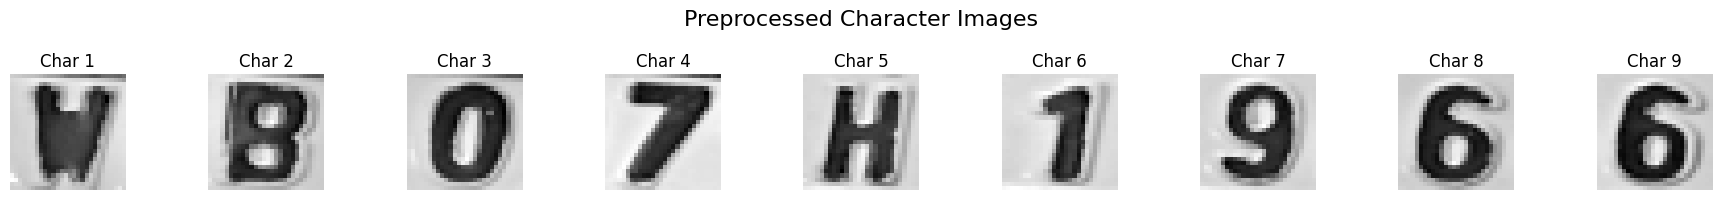

In [5]:
%matplotlib inline

import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math

# -------------------------
# Preprocessing transform
# -------------------------
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# -------------------------
# Sort characters (left-to-right, top-to-bottom)
# chars must come from YOLO/refined boxes
# -------------------------
sorted_chars = sorted(chars, key=lambda b: (b[1] // 50, b[0]))  # adjust 50 if spacing differs

ordered_crops = []
for (x1, y1, x2, y2) in sorted_chars:
    pad = 5
    x0 = max(0, x1 - pad)
    y0 = max(0, y1 - pad)
    x1p = min(W, x2 + pad)
    y1p = min(H, y2 + pad)
    crop = img[y0:y1p, x0:x1p]
    if crop.size:
        ordered_crops.append(crop)

# -------------------------
# Preprocess + visualize
# -------------------------
n = len(ordered_crops)
if n == 0:
    print("No character crops found to preprocess and display.")
else:    
    cols = min(10, n)
    rows = math.ceil(n / cols)
    plt.figure(figsize=(2 * cols, 2 * rows))
    plt.suptitle("Preprocessed Character Images", fontsize=16)

    for i, crop in enumerate(ordered_crops):
        img_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
        
        # Apply preprocessing
        preprocessed_tensor = transform(img_rgb)
        
        # For display: un-normalize [-1, 1] → [0, 1]
        image_to_show = preprocessed_tensor * 0.5 + 0.5 
        
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image_to_show.squeeze(), cmap='gray') 
        plt.title(f"Char {i+1}")
        plt.axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


--- OCR Process Complete ---
Recognized Number Plate: WB07H1966


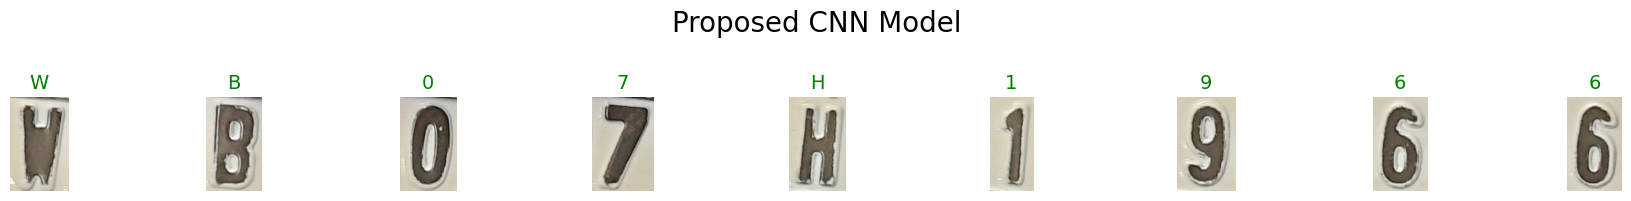

In [8]:
import torch
import torch.nn as nn
import cv2
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import math
import matplotlib.pyplot as plt

# --- Part 1: Import Your Model Architecture ---
from char_cnn import CharCNN

# --- Part 2: Define Transforms and Load Model ---
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Fix: Specify 34 classes to match the saved model
model = CharCNN(num_classes=34)  # Changed from CharCNN() to CharCNN(num_classes=34)
MODEL_PATH = 'char_cnn_best.pth'
model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu')))
model.eval()


# --- Part 3: Define Labels ---
label_map = '0123456789ABCDEFGHJKLMNPQRSTUVWXYZ'

# --- Part 4: Sort Characters by Row + Column (reading order) ---
sorted_chars = sorted(chars, key=lambda b: (b[1] // 50, b[0]))  # adjust row threshold if needed

ordered_crops = []
for (x1, y1, x2, y2) in sorted_chars:
    pad = 5
    x0 = max(0, x1 - pad)
    y0 = max(0, y1 - pad)
    x1p = min(W, x2 + pad)
    y1p = min(H, y2 + pad)
    crop = img[y0:y1p, x0:x1p]
    if crop.size:
        ordered_crops.append(crop)

# --- Part 5: Predict Characters in Correct Order ---
recognized_characters = []

with torch.no_grad():
    for crop in ordered_crops:
        img_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
        input_tensor = transform(img_rgb).unsqueeze(0)  # add batch dim
        output = model(input_tensor)
        _, pred_index = torch.max(output, 1)
        predicted_char = label_map[pred_index.item()]
        recognized_characters.append(predicted_char)

final_plate_number = "".join(recognized_characters)

print("--- OCR Process Complete ---")
print(f"Recognized Number Plate: {final_plate_number}")

# --- Part 6: Visualization (Optional) ---
n = len(ordered_crops)
if n > 0:
    cols = min(10, n)
    rows = math.ceil(n / cols)
    plt.figure(figsize=(2 * cols, 2 * rows))

    # Add a main title for the figure
    plt.suptitle("Proposed CNN Model", fontsize=20)  # <-- Figure title

    for i, (crop, char) in enumerate(zip(ordered_crops, recognized_characters)):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
        plt.title(char, fontsize=14, color="green")  # show predicted char
        plt.axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # adjust layout to make room for suptitle
    plt.show()


--- OCR Process Complete ---
Recognized Number Plate: WB07H1966


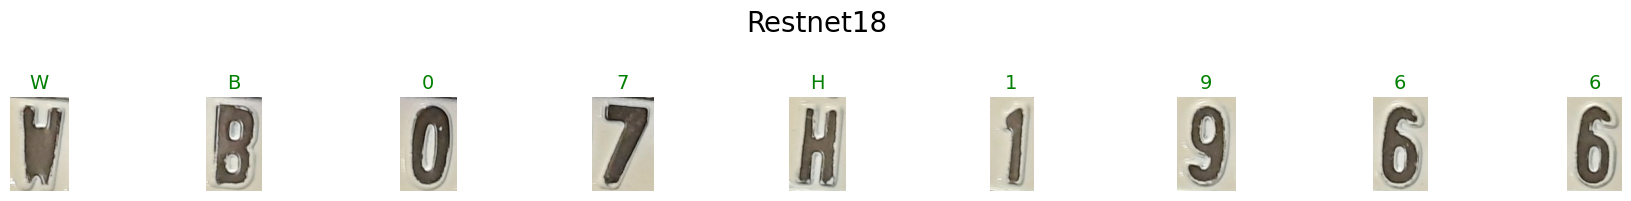

In [7]:
import torch
import torch.nn as nn
import cv2
import numpy as np
import torchvision.transforms as transforms
from torchvision import models
import math
import matplotlib.pyplot as plt

# --- Part 1: Define ResNet-18 ---
num_classes = 34   # Adjust if needed
model = models.resnet18(weights=None)  # fresh ResNet-18

# Modify input for grayscale
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify final FC for classification
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Load trained weights
MODEL_PATH = 'resnet18_best.pth'
model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu')))
model.eval()

# --- Part 2: Define Transform ---
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),   # ResNet-18 prefers bigger input
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# --- Part 3: Sort Characters (row + col) ---
# chars = [(x1, y1, x2, y2), ...] from YOLO/refinement
sorted_chars = sorted(chars, key=lambda b: (b[1] // 50, b[0]))  # adjust threshold if needed

ordered_crops = []
for (x1, y1, x2, y2) in sorted_chars:
    pad = 5
    x0 = max(0, x1 - pad)
    y0 = max(0, y1 - pad)
    x1p = min(W, x2 + pad)
    y1p = min(H, y2 + pad)
    crop = img[y0:y1p, x0:x1p]
    if crop.size:
        ordered_crops.append(crop)

# --- Part 4: Predict in Correct Order ---
label_map = '0123456789ABCDEFGHJKLMNPQRSTUVWXYZ'
recognized_characters = []

with torch.no_grad():
    for crop in ordered_crops:
        img_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
        input_tensor = transform(img_rgb).unsqueeze(0)  # [1, C, H, W]
        output = model(input_tensor)
        _, pred_index = torch.max(output, 1)
        predicted_char = label_map[pred_index.item()]
        recognized_characters.append(predicted_char)

# Final plate string
final_plate_number = "".join(recognized_characters)
print("--- OCR Process Complete ---")
print(f"Recognized Number Plate: {final_plate_number}")

# --- Part 5: Visualization (optional) ---
n = len(ordered_crops)
if n > 0:
    cols = min(10, n)
    rows = math.ceil(n / cols)
    plt.figure(figsize=(2 * cols, 2 * rows))

    # Add a main title for the figure
    plt.suptitle("Restnet18", fontsize=20)  # <-- Figure title

    for i, (crop, char) in enumerate(zip(ordered_crops, recognized_characters)):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
        plt.title(char, fontsize=14, color="green")  # show predicted char
        plt.axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # adjust layout to make room for suptitle
    plt.show()
